In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots, add_identity
from collections import Counter
from matplotlib.lines import Line2D
from tqdm import tqdm

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

image_ctx = {'image.cmap': 'cubehelix', 'image.interpolation': 'none'}

In [5]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11-1/longtogeny_v2_males_raw_usage_matrix_v00.parquet').astype(float)
df = df[keep_syllables].groupby(['age','uuid','mouse']).mean()

ages= df.index.get_level_values('age')
weeks = (ages * 7) // 7
df['binned_age'] = weeks
sample = df.groupby(['mouse','binned_age']).first().reset_index()
#sample2 = df.groupby(['mouse','binned_age']).last().reset_index()
#sample2['binned_age'] = sample2['binned_age']+0.5
#df_male = pd.concat([sample,sample2])
df_male = sample.copy()
df_male.rename(columns={'binned_age': 'age'}, inplace=True)

df_male.set_index(['age', 'mouse'], inplace=True)

In [6]:
# avarage per age or session
m_df=df_male.groupby(['age','mouse']).mean()
avg_m_df = m_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

# sort syllable order by the average
syll_sort_m = (
    avg_m_norm.rolling(5, center=True, win_type="exponential")
    .mean(tau=1.5)
    .idxmax()
    .sort_values()
    .index
)

In [27]:
dist=[]
data=m_norm.copy()
for m, _df in data.groupby('mouse'):
    _df = _df-avg_m_norm
    abs_diff = _df.diff().abs()
    smoothed_usage = abs_diff.rolling(
        2, min_periods=1, win_type="gaussian", center=True
    ).mean(std=2)
    norm_diff = np.linalg.norm(smoothed_usage.to_numpy(), axis=1)
    dist.append(
        pd.Series(norm_diff, index=abs_diff.index)
    )
    
boot_df = pd.DataFrame(dist).T.reset_index()
boot_df = boot_df.melt(id_vars=["age",'mouse'])
boot_df_m=boot_df.copy()

In [28]:
format_plots()

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarn

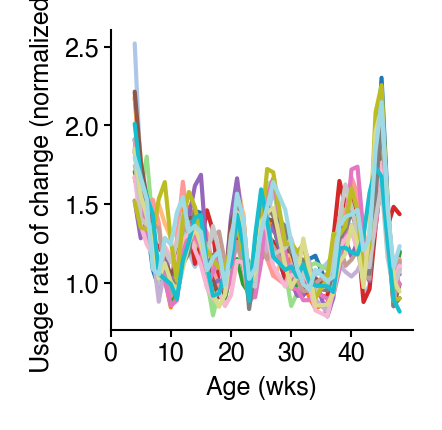

In [29]:
fig = figure(1.3, 1.3)
ax = sns.lineplot(
    data=boot_df_m,
    x="age",
    y="value",
    hue='mouse',
    palette='tab20',
    legend=False,
)

ax.set(ylabel="Usage rate of change (normalized)", xlabel="Age (wks)", xticks = [0,10,20,30,40])
sns.despine()

In [10]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'aging_rate_indv_lines_demean.pdf', bbox_inches='tight')

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


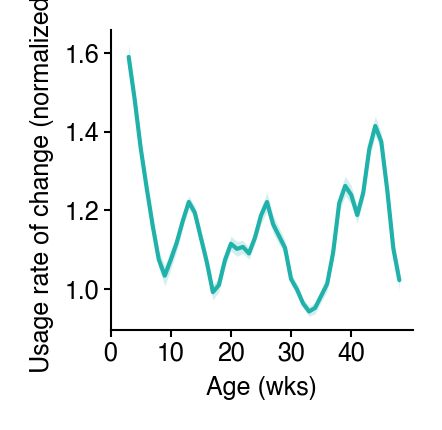

In [11]:
fig = figure(1.3, 1.3)
ax = sns.lineplot(
    data=boot_df_m,
    x="age",
    y="value",
    legend=False,
    errorbar=("se"),
    err_kws=dict(lw=0),
    color='#20B2AA',
)
#plt.ylim(0.2,1)
ax.set(ylabel="Usage rate of change (normalized)", xlabel="Age (wks)", xticks = [0,10,20,30,40])
sns.despine()

In [12]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'aging_rate_indv_avg_demean.pdf', bbox_inches='tight')

In [13]:
from scipy.spatial.distance import jensenshannon
data=m_norm.copy()
dist=[]
for m, _df in data.groupby('mouse'):
    _df=_df-avg_m_norm
    abs_diff = _df.diff().abs()
    smoothed_usage = abs_diff.rolling(
        5, min_periods=1, win_type="gaussian", center=True
    ).mean(std=2)
    
    # Normalize the differences to form probability distributions
    smoothed_usage_norm = smoothed_usage.div(smoothed_usage.sum(axis=1), axis=0).fillna(0)
    
    # Calculate JSD between consecutive time points
    norm_diff = []
    for i in range(1, len(smoothed_usage_norm)):
        p = smoothed_usage_norm.iloc[i-1].to_numpy()
        q = smoothed_usage_norm.iloc[i].to_numpy()
        jsd = jensenshannon(p, q)
        norm_diff.append(jsd)
    
    # Append the JSD values (pad with NaN for the first position to match the index length)
    jsd_series = pd.Series([np.nan] + norm_diff, index=abs_diff.index)
    dist.append(jsd_series)

boot_df = pd.DataFrame(dist).T.reset_index()
boot_df = boot_df.melt(id_vars=["age", 'mouse'])
boot_df_m = boot_df.copy()

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarn

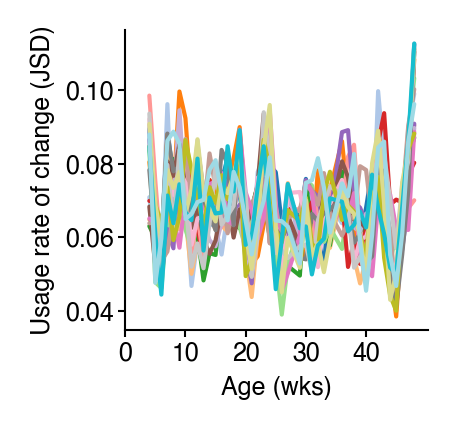

In [14]:
fig = figure(1.3, 1.3)
ax = sns.lineplot(
    data=boot_df_m,
    x="age",
    y="value",
    hue='mouse',
    palette='tab20',
    legend=False,
)

ax.set(ylabel="Usage rate of change (JSD)", xlabel="Age (wks)", xticks = [0,10,20,30,40])
sns.despine()

In [15]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'aging_rate_indv_line_jsd_demean.pdf', bbox_inches='tight')

/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/drl21/miniconda/envs/aging/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


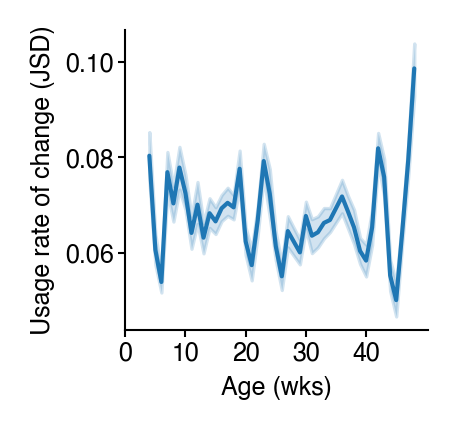

In [16]:
fig = figure(1.3, 1.3)
ax = sns.lineplot(
    data=boot_df_m,
    x="age",
    y="value",
    #hue='mouse',
    #palette='tab20',
    legend=False,
)

ax.set(ylabel="Usage rate of change (JSD)", xlabel="Age (wks)", xticks = [0,10,20,30,40])
sns.despine()

In [17]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig4"/ 'aging_rate_indv_avg_jsd_demean.pdf', bbox_inches='tight')